In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pat
import statsmodels.api as sm

Tutorial: https://github.com/ppsp-team/PyNM/blob/master/tutorials/0-why_normative_modeling.ipynb


## Why Normative Modelling?

### Context
Currently, there are no biological tests to diagnose psychiatric disorders. They are diagnosed using clinical symptoms, which leads heterogeneous groups on the biological level.
The overwhelming majority of analysis in psychiatry & neuroimaging is focussed on group averages, which ignore individual differences.
This leads to losing information about individual subjects and missing patterns that aren't consistent across the entire group. See Marquand et al. 2016.

The classical case-control approach assumes that cases and controls each form a well-defined group. This may often be a reasonable assumption, but in practice many other scenarios are possible.

- A Cases and controls each form a well-defined group
- B The clinical population may be composed of multiple groups, each having distinct pathology
- C Disease-related variation may be nested within healthy variation
- D The clinical group may be diffuse and heterogeneous as a result of misdiagnosis, comorbidities, or an aggregation of different pathologies.

### Example where case-control fails
We'll construct an example in which:

- We know there is a difference between probands and controls (as we've created it)
- Case-control analysis misses 

### Generate Data
First we generate the data:

- We model score = 2*log(age) + gaussian noise 
- Probands have a random offset to their score
- Probands are not distributed evenly throughout the dataset

In [2]:
# Define functions to simulate data

# Generate n_subs samples drawn uniformly from the interval low, high
# 'full' refers to sampling from one normal distribution, while sampling != 'full' generates form two normal distributions
def sample_x(low=1, high=100, n_subs=1000, sampling = 'full'):
    if sampling == 'full':
        x = np.random.uniform(low = low, high = high, size = n_subs)
    else:

        # The first half of n_subs comes from a normal distribution with a mean of 20 and a sd of 10
        # The second half comes from a normal distribution with a mean of 80 and a sd of 10
        # The two sets are concatenates into one array     
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)), np.random.normal(80,10,size=int(n_subs/2))])
        
        # The final array is filtered to only keep values between low and high
        x = x[(x<high) & (x>low)]
    return x


# Define basic logarithmic function
def f(x):

    # f(x)=2⋅ln(x)+ϵ 
    # Formula of the ln(x) scaled by 2, plus a random noise from a normal distribution with mean 0 and sd 1
    return 2*np.log(x)+np.random.randn()


# Define function to generate dataset
def dataset(seed=10, sampling='full'):
   
    # Set seed of random number, ensures reproducibility, default seed is set at 10
    np.random.seed(seed)

    # Generate age parameter based on sample_x funtion defined earlier
    # Sort the ages in ascending order to help visualisation/analysis
    x = np.sort(sample_x(sampling=sampling))

    # Simulate control and proband status, by having two binary arrays with different probabilities of probands/controls
    # 75% of the data points (status_1) have a 20% probability of being assigned 1 (first 75% of ages have a 20% chance of being Proband)
    # 25% of the data points have a 7% probability of being assigned a 1 (Next 25% of ages have a 7% of being a Proband)
    status_1 = np.random.binomial(1,0.2,size=(int(0.75*x.shape[0]))) #np.random.binomial(n: num of trials, p: prob. of success (0 or 1), size = output shape)
    status_2 = np.random.binomial(1,0.07, size=(x.shape[0]-status_1.shape[0]))
    status = np.concatenate([status_1,status_2])

    # Simulate score parameter

    #Create an empty array of length x.shape[0]
    score = np.zeros(x.shape[0])

    # Loop over each element in the array and calculates a score for the corresponding element x[i]
    for i in range(x.shape[0]):

        # Apply a function f(x) to the i-th element of x
        s = f(x[i])

        # Random offset only for probands not for controls
        # Since status = 1 for probands, a random value drawn from a normal distribution with a mean of 0.7 and sd of 1 is added to the score
        s = s + status[i]*np.random.normal(0.7,1)

        # Assign the calculated score s to the i-th position in the empty score array
        score[i] = s
    
    # Transpose switches the rows and columns so that age, status and score become column names instead of row names
    return pd.DataFrame([x, status, score], index=['age', 'status', 'score']).transpose() 


In [3]:
# Create a dataset
df = dataset()
df.head()

,age,status,score
0,1.174205,0.0,1.733340
1,1.329895,1.0,0.201192
2,1.390878,0.0,2.098539
3,1.418167,0.0,0.034777
4,1.436357,0.0,0.509641


### Visualise data

- Controls = 0
- Probands = 1

Extreme scores for a given age are more frequently probands.

More precisely, remember that:
- The first 75% of all sorted ages have a 20% chance of being a proband 
- The remaining 25% of sorted ages have only a 7% of being a proband (less probands in old people)

<Axes: xlabel='age', ylabel='score'>

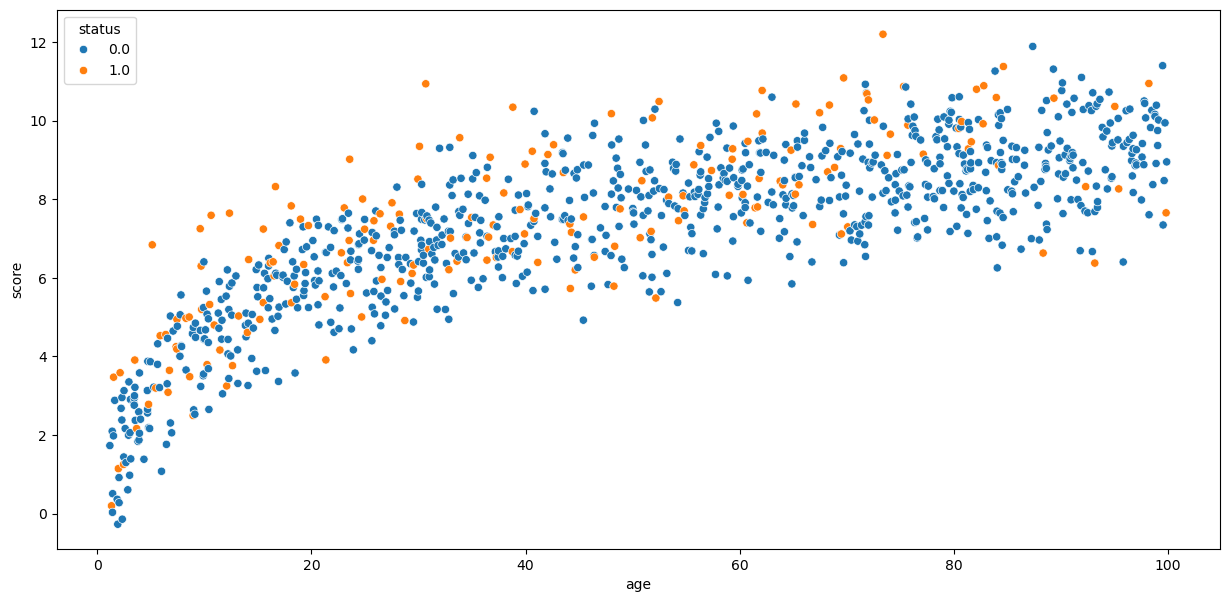

In [4]:
# Plot the data
plt.figure(figsize=(15,7))
sns.scatterplot(x='age', y='score', hue='status', data=df)

### Case-control

- By performing a simple case-control analysis using the status column of the dataset (PROB/CTR), the result is non significant (p=0.88)

In [5]:
# Function to perform statistical analysis using Ordinary ELast Squares (OLS) analysis

def case_control(df, group='status', score='score'):

    # Create a design matrix to model the relationship between score (dependent var) and group (categorical var)
    # C({}) -> indicates that the variable should be treated as a categorical variable
    # format(group) -> dynamically includes the group variable (i.e. status) into the formula string
    # df, the dataframe from which the categorical variable is taken
    # Output is returned as a pandas DataFrame, raise an error if there are any NaN missing values
    # The resulting dmat is a DataFrame that encodes the categorical variable into  dummy/indicator variables, each category has its own column
    dmat = pat.dmatrix('C({})'.format(group), df, return_type='dataframe', NA_action='raise')
    
    # Fit model to the data, dmat allows the OLS model to estimate the effects of the categorical variable status on the dependent variable score
    results = sm.OLS(df[score], dmat).fit()

    # Return the p-values to check whether the impact of status on score is significant
    return results.pvalues.iloc[1] # Use .iloc to access by position

In [6]:
print('p-value =', case_control(df))

p-value = 0.8760719899903934



- NB: if the probands had been distributed evenly across the population (i.e. the probability of being a proband had been 20% across all the population), the p-value would have been significant.



## Normative Modelling

- Normative modelling looks at how individuals deviate from the normal trajectory rather than group averages between probands and controls
- It allows the detection and mapping of distinct patterns of abnormality in individuals without requiring a consistent neurobiological signature across individuals
- Recasts disease as and extreme of the normal range or as a deviation from normal

## Resources


- Normative modeling methods papers:

    1. Marquand et al. Biological Psychiatry 2016, Understanding Heterogeneity in Clinical Cohorts Using Normative  Models: Beyond Case-Control Studies
    2. Rutherford et al. bioRxiv 2021,The Normative Modeling Framework for Computational Psychiatry